In [1]:

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [ ]:
from shapely.geometry import Point, Polygon

In [23]:
c = Point((50,50)).buffer(20)

In [44]:
p = list(c.exterior.coords)

In [45]:
size = (100,100,)
grid = np.full(size, 100)

In [48]:
pp = np.array(list(map(lambda t: [round(t[0]), round(t[1])], p)))
for pos in pp:
    grid[pos] = 0

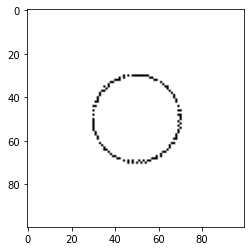

In [49]:
plt.imshow(grid, cmap='gray')

In [652]:
size = (100,100,)
grid = np.zeros(size, dtype=np.uint8)

In [653]:
cv2.circle(grid, (50,50), 30, 1, thickness=2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

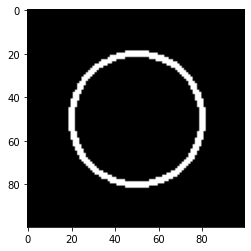

In [654]:
plt.imshow(grid, cmap='gray')

In [655]:
cont, hie = cv2.findContours(grid, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
len(cont[0])

176

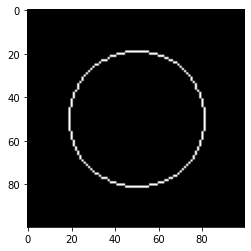

In [656]:
grid2 = np.zeros_like(grid)
for pos in cont[0]:
    grid2[tuple(pos[0])] = 1

# cv2.drawContours(grid2, cont, -1, 1, 1)
plt.imshow(grid2, cmap='gray')

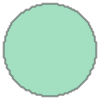

In [657]:
ps = cont[0].reshape((len(cont[0]), 2))
Polygon(ps)

In [658]:
normals = np.zeros(len(ps))
for i in range(len(ps)):
    vec = ps[i] - ps[i-1]
    ang = np.arctan2(vec[1], vec[0]) + np.pi/2
    normals[i] = ang

In [659]:
print(normals)

[ 4.71238898  3.92699082  4.71238898  4.71238898  4.71238898  3.92699082
  4.71238898  4.71238898  3.92699082  3.92699082  4.71238898  4.71238898
  3.92699082  3.92699082  4.71238898  3.92699082  3.92699082  3.92699082
  3.92699082  3.92699082  3.92699082  3.14159265  3.92699082  3.92699082
  3.14159265  3.14159265  3.92699082  3.92699082  3.14159265  3.14159265
  3.92699082  3.14159265  3.14159265  3.14159265  3.92699082  3.14159265
  3.14159265  3.14159265  3.14159265  3.14159265  3.14159265  3.14159265
  3.14159265  3.14159265  3.14159265  2.35619449  3.14159265  3.14159265
  3.14159265  2.35619449  3.14159265  3.14159265  2.35619449  3.14159265
  2.35619449  3.14159265  2.35619449  3.14159265  2.35619449  2.35619449
  2.35619449  2.35619449  2.35619449  2.35619449  2.35619449  1.57079633
  2.35619449  2.35619449  1.57079633  1.57079633  2.35619449  2.35619449
  1.57079633  1.57079633  2.35619449  1.57079633  1.57079633  1.57079633
  2.35619449  1.57079633  1.57079633  1.57079633  1

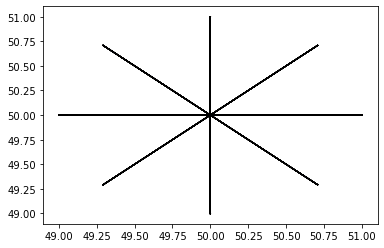

In [664]:
r = 1
x = np.cos(normals) * r
y = np.sin(normals) * r
fig, ax = plt.subplots()
for xi,yi in zip(x,y):
    ax.arrow(x=50, y=50, dx=xi, dy=yi)

(182, 182)

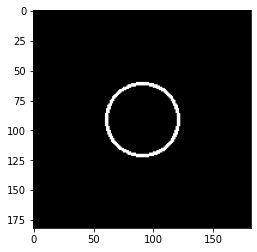

In [1253]:
eps = 0.6
size = 1
movable = 40
pad_width = int(size + np.ceil(movable))

padd = np.pad(grid, (pad_width, pad_width), 'edge')
plt.imshow(padd, cmap='gray')
grid3 = np.zeros_like(padd)

for i, pos in enumerate(ps):
    if i % (size*2) == 0:
        continue
    cut = np.copy(padd[pad_width+pos[0]-size:pad_width+pos[0]+size+1, pad_width+pos[1]-size:pad_width+pos[1]+size+1])
    if np.random.rand() <= eps:
        rr = np.clip(np.random.normal(0, 0.3), -1,1) * movable
        vec = np.array([rr * np.cos(normals[i]), rr * np.sin(normals[i])])
        pp = vec + np.array([vec[0]+pos[0], vec[1]+pos[1]])
    else:
        pp = pos
#     pp[0] = min(max(pp[0], size+1), len(grid)-1-size)
#     pp[1] = min(max(pp[1], size+1), len(grid[0])-1-size)
    pp = np.int16(pp+pad_width)
    grid3[pp[0]-size:pp[0]+size+1, pp[1]-size:pp[1]+size+1] = cut

# grid3 = np.copy(grid3[pad_width:len(grid3)-pad_width, pad_width:len(grid3[0])-pad_width])
grid3.shape


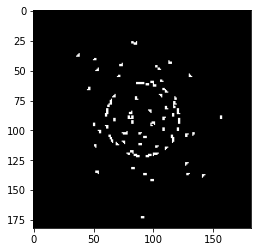

In [1254]:
plt.imshow(grid3, cmap='gray')

In [86]:
from PIL import Image
import requests

url = 'https://thumb.ac-illust.com/87/872f8304f3728f4aea537f97c30e11c6_t.jpeg'
im = Image.open(requests.get(url, stream=True).raw)
im.putalpha(255)

(340, 454, 4)


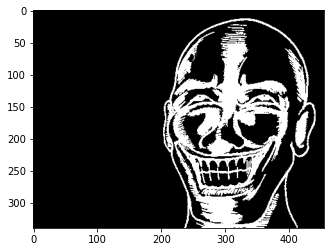

In [87]:
img = np.array(im, dtype=np.uint8)
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# img_HSV = cv2.GaussianBlur(img_HSV, (9, 9), 3)

img_H, img_S, img_V = cv2.split(img_HSV)
_thre, img_cont = cv2.threshold(img_V, 210, 1, cv2.THRESH_BINARY)
img_cont = np.logical_not(img_cont)
plt.imshow(img_cont, cmap='gray')

In [93]:
vthresh = 210
eps = 0.99
size = 10
movable = 3
std = 0.15
is_stride = True
MASK_TYPE_CIRCLE = 'circle'
MASK_TYPE_SQUARE = 'square'

def create_mask(size, mode=MASK_TYPE_CIRCLE) -> np.array:
    ch = None
    if mode == MASK_TYPE_SQUARE:
        ch = np.zeros_like([size*2+1, size*2+1])
    elif mode == MASK_TYPE_CIRCLE:
        y, x = np.meshgrid(np.arange(-size, size+1), np.arange(-size, size+1))
        ch = np.linalg.norm([x,y], axis=0, ord=2)
    
    return ch <= size

def grant(canvas, showpiece, contour, eps, mask, movable, std, is_stride):
    size = len(mask)//2
    normals = np.zeros(len(contour))
    for i in range(len(contour)):
        vec = contour[i] - contour[i-1]
        ang = np.arctan2(vec[1], vec[0]) + np.pi/2
        normals[i] = ang

    for i, pos in enumerate(contour):
        if is_stride and (i % (size*2) != 0):
            continue
        cut = np.copy(showpiece[pos[0]-size:pos[0]+size+1, pos[1]-size:pos[1]+size+1])
        if np.random.rand() <= eps:
            rr = np.clip(np.random.normal(0, std), -1,1) * movable
            vec = np.array([rr * np.cos(normals[i]), rr * np.sin(normals[i])])
            pp = np.uint16(vec+pos)
            canvas_t = canvas[pp[0]-size:pp[0]+size+1, pp[1]-size:pp[1]+size+1]
            canvas_t[mask] = cut[mask]

def kzs(img):
    img = np.array(im, dtype=np.uint8)
    imgb = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_HSV = cv2.cvtColor(imgb, cv2.COLOR_BGR2HSV)
    # img_HSV = cv2.GaussianBlur(img_HSV, (9, 9), 3)

    img_H, img_S, img_V = cv2.split(img_HSV)
    _thre, img_cont = cv2.threshold(img_V, vthresh, 1, cv2.THRESH_BINARY)
    img_cont = np.logical_not(img_cont)
    grid = np.array(img_cont, dtype=np.uint8)
    cont, hie = cv2.findContours(grid, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_NONE)
    contours = [c.reshape((len(c), 2))[:, ::-1] for c in cont]
    
    grid3 = np.copy(img)
    mask = create_mask(size, mode=MASK_TYPE_CIRCLE)

    pad_width = int(size + np.ceil(movable))+1
    grid_r = np.pad(grid3[:,:,0], (pad_width, pad_width), 'edge')
    grid_g = np.pad(grid3[:,:,1], (pad_width, pad_width), 'edge')
    grid_b = np.pad(grid3[:,:,2], (pad_width, pad_width), 'edge')
    grid3 = np.asarray([grid_r, grid_g, grid_b]).transpose(1,2,0)
    pimg = np.copy(grid3)

    for c in contours:
        grant(grid3, pimg, c+pad_width, eps, mask, movable, std, is_stride)

    grid3 = np.copy(grid3[pad_width:len(grid3)-pad_width, pad_width:len(grid3[0])-pad_width])
    
    return grid3

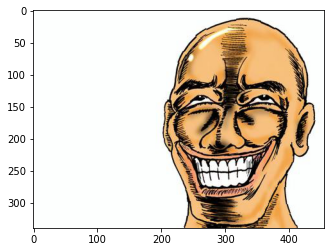

In [89]:
k = 0
plt.imshow(kzs(img))

In [90]:
from PIL import Image, ImageDraw

images = [Image.fromarray(kzs(img)) for _ in range(7)]


images[0].save(f'icon_{k}.gif',
               save_all=True, append_images=images[1:], optimize=False, duration=20, loop=0)
k += 1